In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as tt
import torch.nn as nn
import matplotlib.animation as animation

from torchvision.datasets import ImageFolder
from datetime import datetime
from torchvision.transforms import ToTensor, Normalize
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid, save_image

In [2]:
data_path = 'dataset/'
classes = os.listdir(data_path)
total = 0

for clas in classes:
    names = os.listdir(data_path+clas)
    total += len(names)

len(classes), total

(11, 610)

### Get mean and std
* solo en caso de tomar los 3 canales RGB

In [3]:
train_ds = ImageFolder(data_path, tt.Compose([tt.Resize((128, 128)), tt.ToTensor() ]))

print(len(train_ds))

data_helper = DataLoader(train_ds, batch_size=len(train_ds))

def mean_std(loader):
    images, labels = next(iter(loader))
    # shape of images = [b,c,w,h]
    print(images.shape)
    # print(torch.sum(torch.tensor(images))/len(images))
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

stats = mean_std(data_helper)
stats

610
torch.Size([610, 3, 128, 128])


(tensor([0.7432, 0.7431, 0.7433]), tensor([0.3187, 0.3187, 0.3187]))

In [4]:
# Data transforms (normalization & data augmentation)
# stats = ((0.7622, 0.7620, 0.7622), (0.3057, 0.3058, 0.3057))
# stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
stats = ((0.5), (0.5))
# degrees = (-90,90)
# Means
b_dim = 75 # 150
dim = 64   # 128
train_tfms = tt.Compose([tt.Resize((b_dim, b_dim)),
                         tt.RandomCrop(dim),
                         tt.RandomHorizontalFlip(), 
                         tt.Grayscale(num_output_channels=1), # Usar solo un canal pues son imagenes blanco y negro lol no ocupas mas
                         # tt.RandomVerticalFlip(), 
                         # tt.RandomRotation(degrees),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.5, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)
])

# PyTorch datasets

train_ds = ImageFolder(data_path, train_tfms)
batch_size = 5
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=True ,num_workers=0)
batch_size, len(train_dl), len(train_ds)

(5, 122, 610)

tensor(1.) tensor(-1.)
torch.Size([1, 64, 64])
torch.Size([68, 332, 3])
Wall time: 162 ms


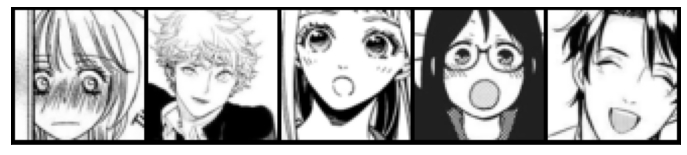

In [5]:
%%time

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 1, 1, 1)
    stds = torch.tensor(stds).reshape(1, 1, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        print(torch.max(images), torch.min(images))
        print(images[0].shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        # denorm_images = images
        row = 5
        ax.imshow(make_grid(denorm_images, nrow=row).permute(1, 2, 0)) #.clamp(0,1))
        print(make_grid(denorm_images, nrow=row).permute(1, 2, 0).shape)
        break

show_batch(train_dl)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

In [7]:
n = nn.ConvTranspose2d(8,16,kernel_size=4, stride=1, padding=0,bias=False)
m = nn.ConvTranspose2d(16,17,kernel_size=6, stride=2, padding=2,bias=False)
b = nn.BatchNorm2d(16)

x = torch.rand([3,8,1,1])
print(x.shape)
x = n(x)
print(x.shape)
x = m(x)
print(x.shape)

torch.Size([3, 8, 1, 1])
torch.Size([3, 16, 4, 4])
torch.Size([3, 17, 8, 8])


## Generator Model 

In [9]:
class Generator(nn.Module):

    def __init__(self, linear_size, conv_size, input_G, device, channels=1):
        super(Generator, self).__init__()
        self.device = device
        self.linear_size = linear_size
        self.conv_size = conv_size
        self.dim = input_G
        self.channels = channels
        linear = []
        conv = []
        doble, same, ini = (4,2,1), (3,1,1), (4,1,0) # 1,1 to 4,4
        for i in range(len(linear_size)-1):
            linear.extend(self.LinearLayer(linear_size[i], linear_size[i+1]))
        conv.extend(self.ConvLayer(self.dim, conv_size[0], values=ini) )
        for i in range(len(conv_size)-1):
            conv.extend(self.ConvLayer( conv_size[i], conv_size[i], values=same) )
            conv.extend(self.ConvLayer( conv_size[i], conv_size[i+1], values=doble) )
        self.generator_linear = nn.Sequential(*linear)
        self.generator_conv   = nn.Sequential(*conv)
        
    def forward(self, x):
        # x = self.generator_linear(x)
        x = x.reshape(-1,self.dim,1,1)
        x = self.generator_conv(x)
        return x

    def ConvLayer(self, in_size, out_size, values=(3,1,1), output=False, pool=False):
        kernel, stride, padding = values
        # values = (6,2,2) -> doble    (3,1,1) -> same
        layers = [ nn.ConvTranspose2d(in_size, out_size, kernel_size=kernel, stride=stride, padding=padding, bias=False, device=self.device) ]
        if pool:
            layers.append( nn.MaxPool2d(2, 2) )
        if not output:
                layers.extend([ nn.BatchNorm2d(out_size),
                                nn.ReLU(True)])
        else:
            layers.append( nn.Tanh() )
        
        return layers

    def LinearLayer(self, input, output):
        return [ nn.Linear(input, output, device=self.device), nn.BatchNorm1d(output), nn.ReLU(True)]
    

## Discriminator

In [26]:
class Discriminator(nn.Module):

    def __init__(self, linear_size, conv_size, device, relu_lr=0.2, dim=128, channels=1):
        super(Discriminator, self).__init__()
        self.device = device
        self.linear_size = linear_size
        self.conv_size = conv_size
        self.channels = channels
        self.dim = dim
        linear = []
        conv = []
        doble, same, ini = (4,2,1), (3,1,1), (4,1,0)
        conv.extend(self.ConvLayer(channels, conv_size[0], same) )
        for i in range(len(conv_size)-1):
            conv.extend(self.ConvLayer( conv_size[i], conv_size[i+1], values=doble) )
            dim /= 2
        linear.append( nn.Flatten() )
        linear.extend( self.LinearLayer(int(conv_size[-1]*dim*dim), linear_size[0]) )
        for i in range(len(linear_size)-1):
            linear.extend(self.LinearLayer(linear_size[i], linear_size[i+1], last=( i == len(linear_size)-2 ) ))
        self.discriminator_linear = nn.Sequential(*linear)
        self.discriminator_conv   = nn.Sequential(*conv)

    def forward(self, x):
        x = self.discriminator_conv(x)
        x = self.discriminator_linear(x)
        return x

    def ConvLayer(self, in_size, out_size, values=(3,1,1), pool=False):
        kernel, stride, padding = values
        # values = (4,2,1) -> doble    (3,1,1) -> same
        layers = [  nn.Conv2d(in_size, out_size, kernel_size=kernel, stride=stride, padding=padding, bias=True, device=self.device),
                    # nn.BatchNorm2d(out_size),
                    nn.LeakyReLU(relu_lr, inplace=True)]
        if pool:
            layers.append( nn.MaxPool2d(2, 2) )
        return layers

    def LinearLayer(self, input, output, last=False):
        layers = [ nn.Linear(input, output, device=self.device), nn.Dropout(0.2)] #, nn.BatchNorm1d(output)] 
        if last:  layers.append( nn.Sigmoid() )
        else:     layers.append( nn.LeakyReLU(relu_lr, inplace=True) )
        return layers
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.5000],
        [0.5311],
        [0.5375],
        [0.5310],
        [0.5299],
        [0.5363],
        [0.5280],
        [0.5000],
        [0.5364],
        [0.5000]], grad_fn=<SigmoidBackward>)


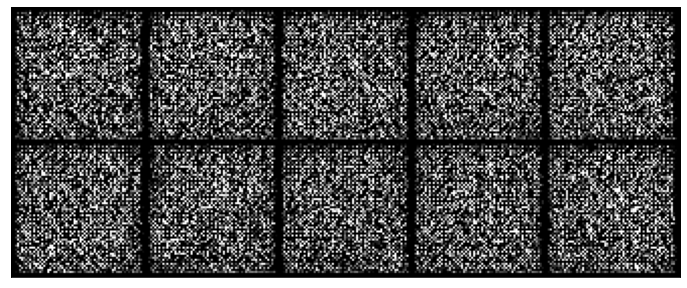

In [27]:
linear_size_G = (64, 128, 256) # out 
conv_size_G   = (128, 64, 32, 16, 1) # 4,8,16,32,64
linear_size_D = (256, 64, 16, 1)
conv_size_D   = (32, 64, 128, 256)
input_G = 1024
relu_lr = 0.2
channels = 1
dim = 64

G = Generator(linear_size_G, conv_size_G, input_G, device, channels=channels)
D = Discriminator(linear_size_D, conv_size_D, device, relu_lr=relu_lr, dim=dim, channels=channels)

G.to(G.device)
D.to(D.device)

x = torch.tensor(np.random.uniform( -1., 1.,[10, input_G]), dtype=torch.float32)
out = G(x).detach()
print(D(out))
out = out.reshape(-1,1,dim,dim) 
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
grid = make_grid(out, nrow=5).permute(1,2,0)
ax.imshow(grid) 

# GAN Model

In [33]:
class GAN():

    def __init__(self, G, D, lr, train_dl, G_input_size, batch_size, device, rows, pxls, dim, channels):
        self.dim = dim
        self.pxls = pxls
        self.channels = channels
        self.device = device
        self.rows = rows
        self.batch_size = batch_size
        self.samples_size = 25
        self.train_dl = train_dl
        self.G = G
        self.D = D
        self.G_input_size = G_input_size
        self.lr = lr
        self.D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)
        self.G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
        self.G_loss = nn.BCELoss()
        self.D_loss = nn.BCELoss()
        self.samples = self.get_noise(samples=True)
        self.G_loss_it, self.D_loss_it = [], []
        self.real_pred_it, self.fake_pred_it = [], []

    def grad_reset(self):
        self.D_optimizer.zero_grad(set_to_none=True)
        self.G_optimizer.zero_grad(set_to_none=True)

    def G_train(self):
        # Genera vectores random
        noise = self.get_noise()
        # Genera imagenes 
        out = self.G(noise)
        # Label 0 para imagenes falsas
        # Pero usamos 1 para confundir a la red
        labels = torch.ones(batch_size, 1, device=self.device)
        # Calcular loss
        pred_labels = self.D(out)
        loss = self.G_loss(pred_labels, labels)
        # Reset gradientes
        self.grad_reset()
        # Calcular gradientes
        loss.backward()
        # Optimizar
        self.G_optimizer.step()
        return loss, out

    def D_train(self, images):
        # Genera vectores random
        noise = self.get_noise()
        # Label 1 para imagenes reales
        real_labels = torch.ones(batch_size, 1, device=self.device)
        # Label 0 para imagenes falsas
        fake_labels = torch.zeros(batch_size, 1, device=self.device)

        # Genera imagenes 
        out = self.G(noise)

        # Prediccion imagenes reales
        real_pred = self.D(images)
        # Prediccion imagenes fake
        fake_pred = self.D(out)

        # Calcular loss
        real_loss = self.D_loss(real_pred, real_labels)
        fake_loss = self.D_loss(fake_pred, fake_labels)

        # Sumar loss fn
        loss = real_loss + fake_loss
        # Reset gradientes
        self.grad_reset()
        # Calcular gradientes
        loss.backward()
        # Optimizar
        self.D_optimizer.step()
        return loss, real_pred, fake_pred
        
    def fit(self, its, folder="samples", saveLoss=False):
        torch.cuda.empty_cache()
        begin_time = datetime.now()
        for it in range(its):
            batch_len = len(train_dl)
            for i, (images, labels) in enumerate(self.train_dl):
                
                self.G.train()
                self.D.train()

                images = images.reshape(batch_size, self.channels, self.dim, self.dim)
                
                loss_d, real_pred, fake_pred = self.D_train(images)
                loss_g, _ = self.G_train()
                
                if (i+1) % 10 == 0:
                    self.D_loss_it.append(loss_d.item())
                    self.G_loss_it.append(loss_g.item())
                    self.real_pred_it.append(real_pred.mean().item())
                    self.fake_pred_it.append(fake_pred.mean().item())
                    act_time = datetime.now()
                    print('Epoch[{}/{}]  Batch[{}/{}]  D_loss:{:.5f}  G_loss:{:.5f}  D(x)_mean:{:.5f}  D(G(p))_mean:{:.5f}  Time:{}'.format(
                        it+1, its, i+1, batch_len, loss_d.item(), loss_g.item(),
                        real_pred.mean().item(), fake_pred.mean().item(), act_time - begin_time
                    ))

            if saveLoss: self.plot_loss(save=True, file_name='loss_log_{0:0=4d}'.format(len(self.D_loss_it)))
            self.save_image('sample_{0:0=4d}'.format(it), folder=folder)
            self.save_models()

        return
            
    def random_generator(self):
        random_vector = self.get_noise()
        out = self.G(random_vector)
        plt.imshow( out[0].detach().reshape(self.dim,self.dim,-1) )
        return out[0], self.D(out)[0]

    def show_samples(self, batch = False, show = True):
        out = self.G(self.samples).detach().reshape(-1,self.channels,self.dim,self.dim) 
        if batch == True: out = self.take_random_batch()
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        grid = self.to_grid(out)
        if show: ax.imshow(grid) 
        return fig, ax, out
        
    def save_models(self, folder='models'):
        model_path = folder
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        torch.save(self.G.state_dict(), model_path+'/G.ckpt')
        torch.save(self.D.state_dict(), model_path+'/D.ckpt')

    def save_image(self, file_name, folder="samples", batch =False):
        samples_path = folder
        if not os.path.exists(samples_path):
            os.makedirs(samples_path)
        image = self.G(self.samples).detach().reshape(-1, self.channels, self.dim, self.dim)
        if batch == True: image = self.take_random_batch()
        save_image(image, os.path.join(samples_path, f'{file_name}.png'), nrow=self.rows)

    def take_random_batch(self):
        for images, labels in self.train_dl:
            return images
        return None

    def to_grid(self, images):
        return make_grid(images, nrow=self.rows).permute(1,2,0)

    def get_noise(self, samples=False):
        return torch.tensor(np.random.uniform( -1., 1., #self.pxls[0],self.pxls[1],
            [ self.batch_size if not samples else self.samples_size, 
                self.G_input_size]), dtype=torch.float32, device=device)

    def normalize(self, x):
        return (x + 1) / 2

    def plot_loss(self, save=False, file_name='loss-log', folder="loss"):
        plt.plot(self.D_loss_it, '-')
        plt.plot(self.G_loss_it, '-')
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Iteraciones')
        plt.ylabel('Loss')
        plt.title('Loss')
        if save:
            if not os.path.exists(folder):
                os.makedirs(folder)
            plt.savefig(os.path.join(folder, f'{file_name}.png'))
        else:
            plt.show()
    
    def plot_score(self):
        plt.plot(self.real_pred_it, '-')
        plt.plot(self.fake_pred_it, '-')
        plt.xlabel('Iteraciones')
        plt.ylabel('Score')
        plt.legend(['Real', 'Fake'])
        plt.title('Scores')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


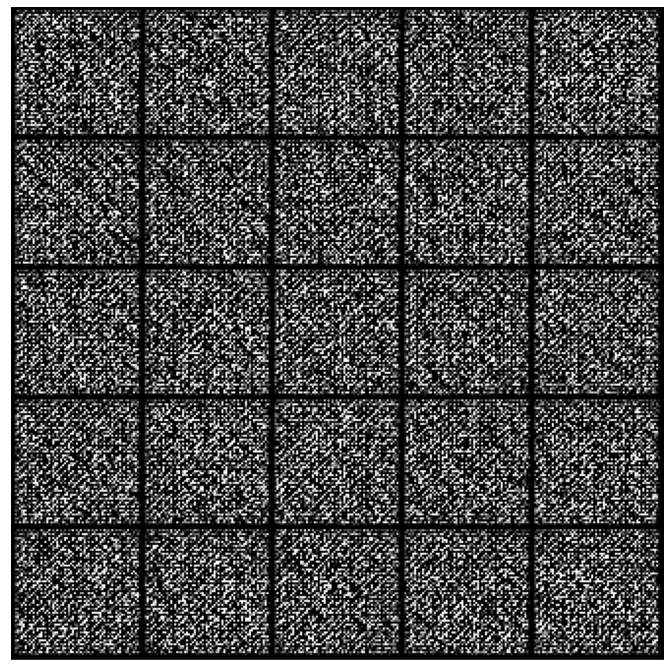

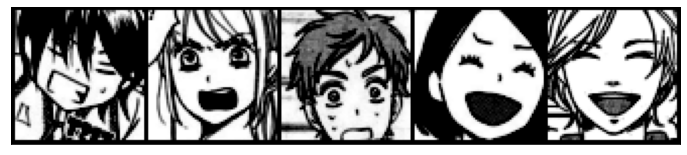

In [34]:
linear_size_G = (64, 128, 256) # out 
conv_size_G   = (128, 64, 32, 16, 1) # 4,8,16,32,64
linear_size_D = (256, 64, 16, 1)
conv_size_D   = (32, 64, 128, 256)
input_G = 1024
relu_lr = 0.2
channels = 1
dim = 64

G = Generator(linear_size_G, conv_size_G, input_G, device, channels=channels)
D = Discriminator(linear_size_D, conv_size_D, device, relu_lr=relu_lr, dim=dim, channels=channels)

G.to(G.device)
D.to(D.device)

lr = 0.0002
pxls = (-1., 1.)
gan = GAN(G, D, lr, train_dl, input_G, batch_size, device=device, rows=5, pxls=pxls, dim=dim,  channels=channels)

out = gan.show_samples()
out = gan.show_samples(batch=True)

# gan.save_image('test')
# gan.save_image('batch', batch=True)
# gan.save_models()

Epoch[1/10]  Batch[10/122]  D_loss:0.00263  G_loss:9.71845  D(x)_mean:0.99998  D(G(p))_mean:0.00260  Time:0:00:03.493760
Epoch[1/10]  Batch[20/122]  D_loss:0.13998  G_loss:6.58868  D(x)_mean:0.90000  D(G(p))_mean:0.00135  Time:0:00:07.061132
Epoch[1/10]  Batch[30/122]  D_loss:0.28222  G_loss:7.05305  D(x)_mean:0.99997  D(G(p))_mean:0.20489  Time:0:00:11.084914
Epoch[1/10]  Batch[40/122]  D_loss:0.28331  G_loss:5.28451  D(x)_mean:0.90000  D(G(p))_mean:0.10597  Time:0:00:14.967929
Epoch[1/10]  Batch[50/122]  D_loss:0.14014  G_loss:8.68432  D(x)_mean:0.99999  D(G(p))_mean:0.10150  Time:0:00:19.276935
Epoch[1/10]  Batch[60/122]  D_loss:0.41778  G_loss:7.79994  D(x)_mean:0.89823  D(G(p))_mean:0.20012  Time:0:00:24.071487
Epoch[1/10]  Batch[70/122]  D_loss:0.42091  G_loss:4.24564  D(x)_mean:0.80000  D(G(p))_mean:0.10496  Time:0:00:28.495940
Epoch[1/10]  Batch[80/122]  D_loss:0.41592  G_loss:10.52219  D(x)_mean:0.89999  D(G(p))_mean:0.20002  Time:0:00:32.808898
Epoch[1/10]  Batch[90/122]  D_l

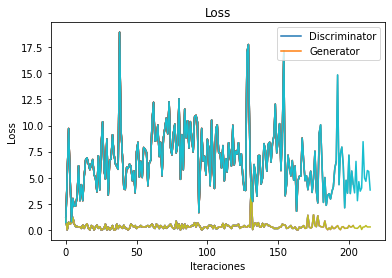

In [37]:
%%time
gan.fit(10, folder="samples", saveLoss=True)

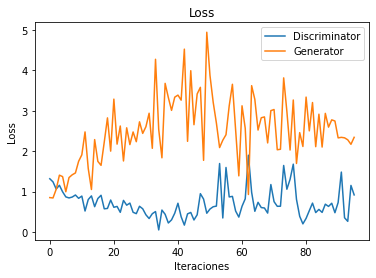

In [344]:
gan.plot_loss()

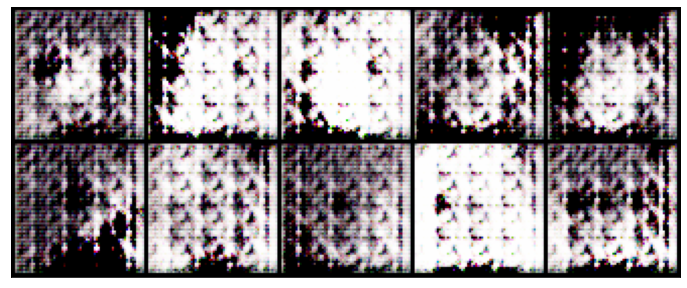

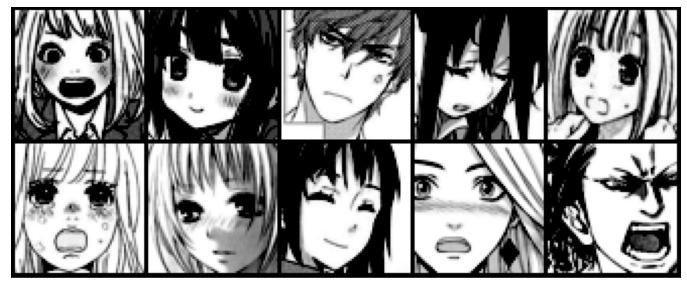

In [311]:
out = gan.show_samples()
out = gan.show_samples(batch=True)

In [ ]:
x = torch.tensor(np.random.uniform( -1., 1.,[10, 64]), dtype=torch.float32)
out = G(x).detach().reshape(-1,1,dim,dim) 
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
grid = make_grid(out, nrow=5).permute(1,2,0)
ax.imshow(grid) 